In [72]:
%matplotlib notebook

# 1. Generating orientations

### A regular grid from a spherical mesh
The output is euler angles of orientations, with the first euler angle constrained to 0

In [495]:
from diffsims.generators.rotation_list_generators import get_beam_directions_grid

grid = get_beam_directions_grid("cubic",1, mesh="icosahedral")

In [74]:
grid.shape

(1596, 3)

### A random grid
We sample the sphere after https://mathworld.wolfram.com/SpherePointPicking.html. We then map the beam directions to the fundamental zone of the cube, all directions contained in the solid angle spanned by 001-101-111. Again here the first euler angle will be constrained

In [496]:
import numpy as np
from diffsims.generators.sphere_mesh_generators import beam_directions_grid_to_euler

In [497]:
# random sampling in the fundamental cube zone
def _get_random_orientations_fundamental_cube(number):
    """after https://mathworld.wolfram.com/SpherePointPicking.html"""
    xyz = np.random.normal(size=(number, 3))
    xyz = np.abs(xyz.T/np.linalg.norm(xyz, axis=1)).T
    xyz = np.sort(xyz, axis=1)
    xyz[:, [0, 1]] = xyz[:, [1, 0]] 
    return beam_directions_grid_to_euler(xyz)
    

In [498]:
random_grid = _get_random_orientations_fundamental_cube(grid.shape[0])

### Verifying the grids
We map the grid onto the stereographic projection

In [499]:
from orix.quaternion.rotation import Rotation
from orix.vector.vector3d import Vector3d
rotations_regular =  Rotation.from_euler(np.deg2rad(grid))
rotations_random =  Rotation.from_euler(np.deg2rad(random_grid))
rot_reg_test = rotations_regular*Vector3d.zvector()
rot_rand_test = rotations_random*Vector3d.zvector()

In [500]:
import matplotlib.pyplot as plt

In [501]:
from orix.plot.stereo_plot import StereoPlot

<IPython.core.display.Javascript object>


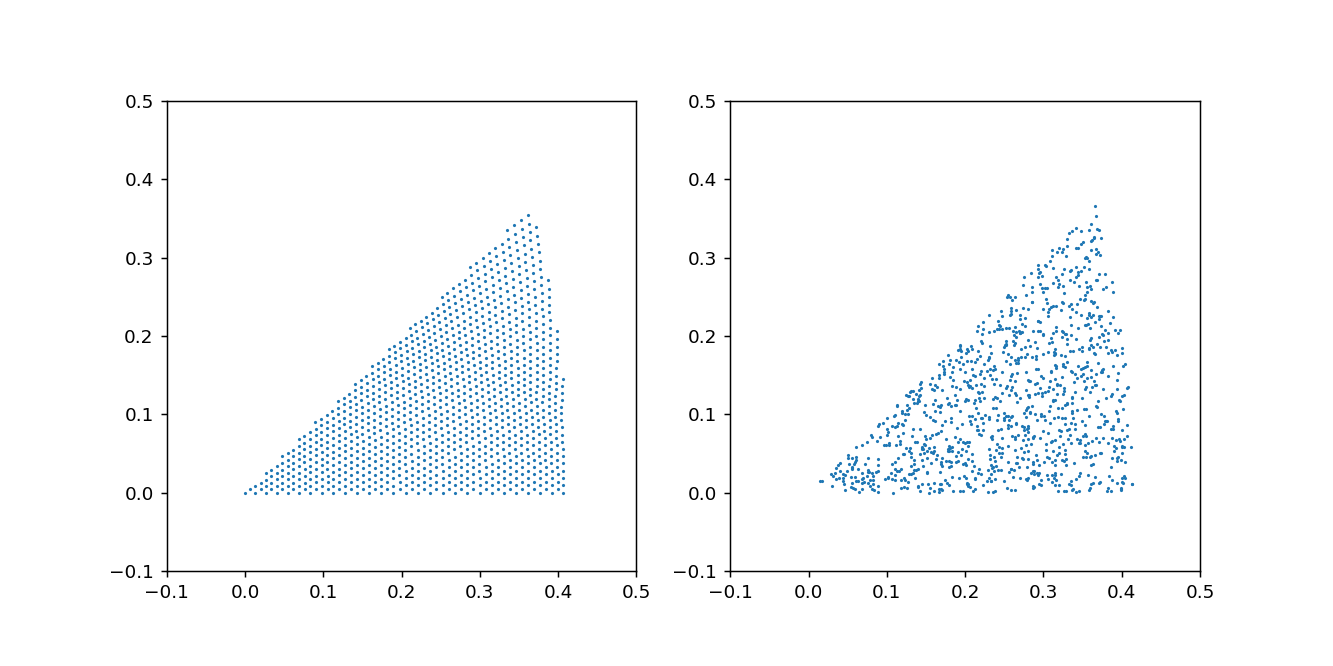

(-0.1, 0.5)

In [502]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={"projection": "stereographic"})
ax1, ax2 = ax.ravel()
ax1.scatter(rot_reg_test, s = 0.5)
ax2.scatter(rot_rand_test, s = 0.5)
ax1.set_xlim(-0.1, 0.5)
ax1.set_ylim(-0.1, 0.5)
ax2.set_xlim(-0.1, 0.5)
ax2.set_ylim(-0.1, 0.5)

### Releasing the constraint on the third angle
All the orientations inside this triangle will be unique for the cubic crystal system with no overlap. We can now freely choose the third euler angle on a uniform distribution to get access to all possible unique orientations of the cube. Only exactly in the coorners will there be additional symmetry: at the 001 corner 4 times rotational symmetry, at the 101 corner 2 times, at the 111 corner 3 times.

In [142]:
random_grid[:, 0] = np.random.uniform(0, 360, size=random_grid.shape[0])
random_grid.shape

(1596, 3)

# 2. Generating a diffraction pattern simulation
* Loading a structure
* Set up the simulation
* Generate library

In [143]:
from diffsims.libraries.structure_library import StructureLibrary
from diffsims.generators.diffraction_generator import DiffractionGenerator
from diffsims.generators.library_generator import DiffractionLibraryGenerator

In [144]:
import diffpy
structure_aus = diffpy.structure.loadStructure("Data/austeniteLP.cif")
structure_G = diffpy.structure.loadStructure("Data/g-phaseLP.cif")

In [145]:
# diffraction generator controls how the patterns will be simulated
diff_gen = DiffractionGenerator(accelerating_voltage=200, shape_factor_model="lorentzian")

Extract relevant information from the image

In [146]:
import hyperspy.api as hs
from tqdm import tqdm

In [560]:
experimental_data = hs.load("data/subset_data.hspy")

In [114]:
experimental_data.axes_manager

<Axes manager, axes: (2, 2|256, 256)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               x |      2 |      0 |   2e+02 |       2 |     nm 
               y |      2 |      0 |   2e+02 |       2 |     nm 
---------------- | ------ | ------ | ------- | ------- | ------ 
              kx |    256 |        |    -1.6 |   0.013 | $A^{-1}$ 
              ky |    256 |        |    -1.6 |   0.013 | $A^{-1}$

In [563]:
# experimental values necessary to scale the simulations
half_width_image = experimental_data.axes_manager["kx"].size//2
diffraction_scale = experimental_data.axes_manager["kx"].scale
reciprocal_radius = np.sqrt(2)*half_width_image*diffraction_scale

### Manual loop

In [375]:

simulations = []
for orientation in tqdm(grid):
    simulation = diff_gen.calculate_ed_data(
        structure_aus,
        reciprocal_radius,
        orientation,
        with_direct_beam=False,
        max_excitation_error=0.6e-1,
    )
    simulation.calibration = diffraction_scale
    simulations.append(simulation)

100%|██████████| 1596/1596 [00:20<00:00, 77.42it/s]


### The "recommended" way to generate the simulations is with Generating with the librarygenerator

In [151]:
# list of phase names, list of structures, list of orientation grids to simulate
library_phases = StructureLibrary(["steel", "g"], [structure_aus, structure_G], [grid, grid])
lib_gen = DiffractionLibraryGenerator(diff_gen)
diff_lib = lib_gen.get_diffraction_library(library_phases,
                                           calibration=diffraction_scale,
                                           reciprocal_radius=reciprocal_radius,
                                           half_shape=(half_width_image, half_width_image),
                                           with_direct_beam=False,
                                           max_excitation_error=0.6e-1)

In [153]:
# save the library
diff_lib.pickle_library('./Data/phase_template_library.pickle')

### Plotting the results

In [561]:
test_simulation = simulations[0] #0 corresponds to 001 diffraction pattern

<IPython.core.display.Javascript object>


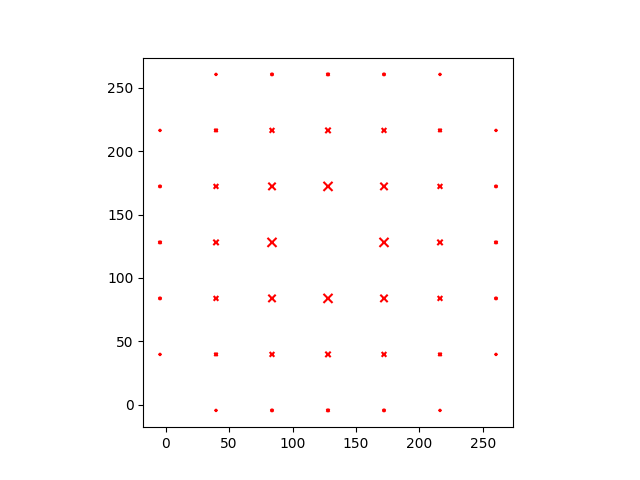

In [566]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
#ax.imshow(experimental_data.inav[0,0], vmax=1000)

coords = test_simulation.calibrated_coordinates
coords[:, 0] += half_width_image
coords[:, 1] += half_width_image

ax.scatter(coords[:,0], coords[:,1], s = np.sqrt(test_simulation.intensities), color="red", marker="x")

# 3. Matching in-plane orientation

In [116]:
from skimage.transform import warp_polar

In [117]:
image = experimental_data.inav[0,0].data

In [118]:
center_coordinates = np.where(image == image.max())
polar_image = warp_polar(image, center=center_coordinates)
polar_image.shape

(360, 182)

<IPython.core.display.Javascript object>


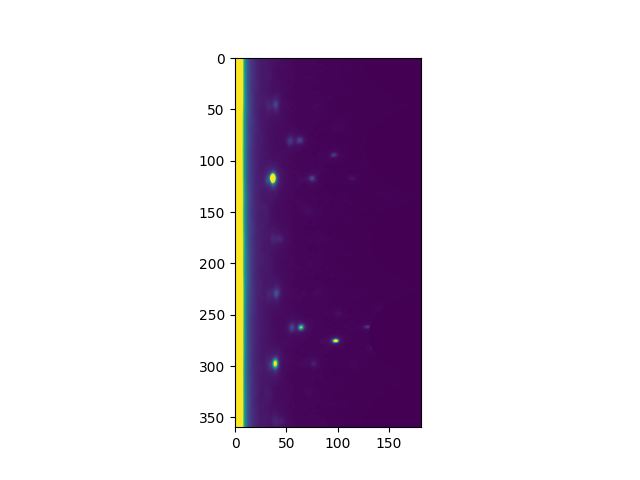

In [381]:
fig, ax = plt.subplots()
ax.imshow(polar_image, vmax=0.1)

# To work with numba more easily, convert list to array

In [164]:
num_spots = [i.intensities.shape[0] for i in simulations]
max_spots = max(num_spots)
positions = np.zeros((max_spots, 2, len(simulations)))
intensities = np.zeros((max_spots, len(simulations)))
for i, j in enumerate(simulations):
    x = j.calibrated_coordinates[:,0]
    y = j.calibrated_coordinates[:,1]
    intensity = j.intensities/np.linalg.norm(j.intensities)
    positions[:x.shape[0],0,i]=x
    positions[:y.shape[0],1,i]=y
    intensities[:intensity.shape[0], i]=intensity

In [165]:
print(intensities.shape)
print(positions.shape)

(66, 1596)
(66, 2, 1596)


### Helper functions for transformations

In [121]:
from numba import jit, njit, vectorize, guvectorize, prange

In [122]:
@njit
def _cartesian_to_polar(pixel_coords):
    polar_coords = np.zeros_like(pixel_coords)
    imag = (pixel_coords[:,0])+1j*(pixel_coords[:,1])
    polar_coords[:, 0] = np.abs(imag)
    polar_coords[:, 1] = np.angle(imag)/np.pi/2*360
    polar_coords[:, 1] = np.mod(polar_coords[:, 1], 360)
    return polar_coords

In [127]:
%%time
polar_test = _cartesian_to_polar(test_simulation.calibrated_coordinates)

CPU times: user 191 µs, sys: 22 µs, total: 213 µs
Wall time: 270 µs


In [133]:
# shift the points in polar coordinates manually
# it is assumed intensity vectors are already normalized!
@njit
def full_correlation_function(x, y):
    N = x.shape[0]
    sumx = np.sum(x)
    sumy = np.sum(y)
    return (N*np.sum(x * y) - sumx*sumy)/np.sqrt(
            (N*np.sum(x**2)-sumx**2)*(N*np.sum(y**2)-sumy**2))
    
    
@njit
def correlation_function(x, y):
    return np.sum(np.multiply(x, y))

@njit
def match_polar_to_template(polar_image, xy_coordinates, intensity, d_r):
    d_theta = 360/polar_image.shape[0]
    polar_coords = _cartesian_to_polar(xy_coordinates)
    r_template = np.rint(polar_coords[:, 0]/d_r)
    theta_template = np.rint(polar_coords[:, 1]/d_theta)
    condition = r_template < polar_image.shape[1]
    r_template = r_template[condition].astype(np.uint16)
    theta_template = theta_template[condition]
    intensity = intensity[condition]
    correlation = np.zeros(polar_image.shape[0])
    for i in prange(polar_image.shape[0]):
        theta_compare = np.mod(theta_template + i, polar_image.shape[0]).astype(np.uint16)
        image_intensities = np.zeros_like(theta_compare, dtype=np.float64)
        for j in range(theta_compare.shape[0]):
            yy = theta_compare[j]
            xx = r_template[j]
            image_intensities[j] = polar_image[yy, xx]
        correlation[i] = correlation_function(image_intensities, intensity)
    return correlation
    
@njit#(parallel=True, nogil=True)
def match_library_to_polar(polar_image, coordinates, intensities, d_r):
    correlations = np.zeros(intensities.shape[1])
    angles = np.zeros(intensities.shape[1])
    correlations_180 = np.zeros(intensities.shape[1])
    d_theta = 360/polar_image.shape[0]
    half_index = polar_image.shape[0]//2
    for i in prange(intensities.shape[1]):
        intensity = intensities[:, i]
        xy = coordinates[:, :, i]
        match = match_polar_to_template(polar_image, xy, intensity, d_r)
        half_match = match[:half_index]
        max_index = np.where(half_match == np.max(half_match))[0][0]
        correlations[i] = half_match[max_index]
        angles[i] = max_index*d_theta
        correlations_180[i] = match[max_index + half_index]
    return angles, correlations, correlations_180


In [149]:
%%time
cor = match_polar_to_template(polar_image, test_simulation.calibrated_coordinates, test_simulation.intensities, 1)

CPU times: user 1.02 ms, sys: 31 µs, total: 1.05 ms
Wall time: 1.07 ms


<IPython.core.display.Javascript object>


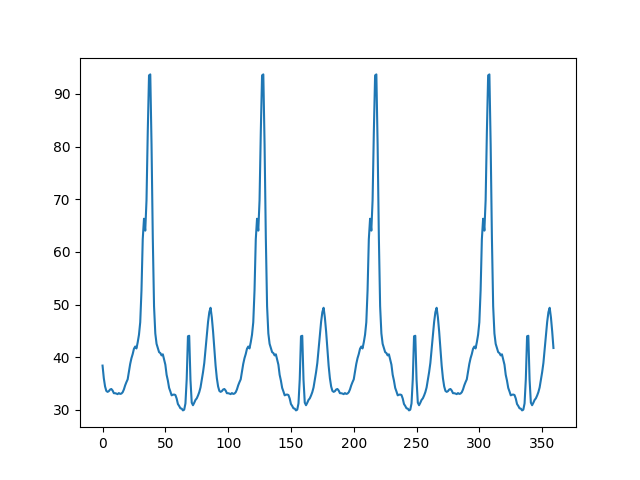

In [548]:
fig, ax = plt.subplots()
ax.plot(np.arange(cor.shape[0]), cor)

In [166]:
%%time
angles, correlations, correlations_180 = match_library_to_polar(polar_image, positions, intensities, 1)

CPU times: user 783 ms, sys: 11.7 ms, total: 794 ms
Wall time: 828 ms


### Verification of the result via plot

In [79]:
# make an interpolation
from orix.projections.stereographic_projection import StereographicProjection
from scipy.interpolate import griddata
xy = StereographicProjection.project(rot_reg_test)
z = correlations
xi = np.linspace(-0.1, 0.5, 1000)
yi = np.linspace(-0.1, 0.5, 1000)
Xi, Yi = np.meshgrid(xi, yi)
zi = griddata(xy, z, (Xi, Yi), method='cubic')

NameError: name 'correlations' is not defined

<IPython.core.display.Javascript object>


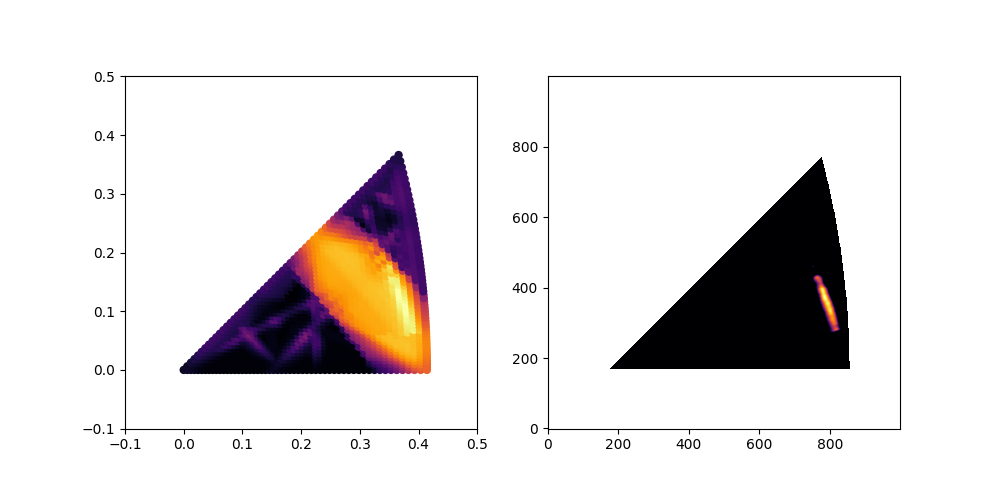

(-0.1, 0.5)

In [552]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={"projection": "stereographic"})
ax1, ax2 = ax.ravel()
ax1.scatter(rot_reg_test, s = 25, c = correlations, cmap="inferno")
ax2.imshow(zi, cmap="inferno", vmin=0.2)
ax2.invert_yaxis()
ax1.set_xlim(-0.1, 0.5)
ax1.set_ylim(-0.1, 0.5)

<IPython.core.display.Javascript object>


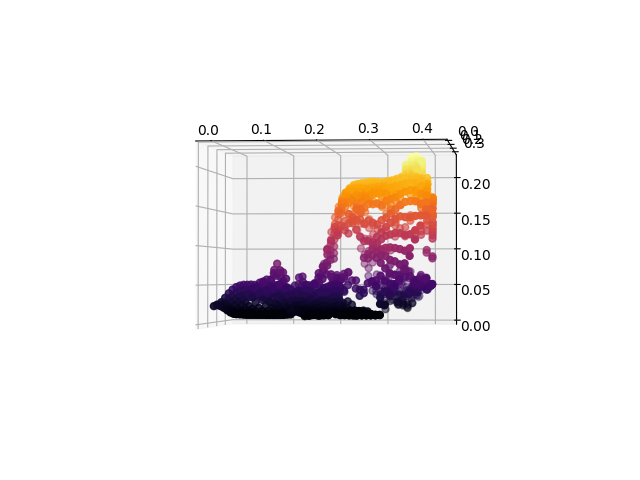

In [404]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xy[:,0], xy[:,1], z, s=25, c=z, cmap="inferno")

In [570]:
max_cor = np.max(correlations)
best_index = np.where(correlations == max_cor)[0][0]
best_index

1071

## Wu's method of integrating over azimuthal angle

In [553]:
@njit
def match_library_to_polar_fast(polar_image, coordinates, intensities):
    polar_sum = np.sum(polar_image, axis=0).astype(np.float64)
    polar_sum = polar_sum / np.linalg.norm(polar_sum)
    coors = np.zeros(intensities.shape[1], dtype=np.float64)
    N = polar_sum.shape[0]
    for i in range(intensities.shape[1]):
        intensity = intensities[:, i]
        xy = coordinates[:, :, i]
        r_template = np.sqrt(xy[:,0]**2 + xy[:, 1]**2)
        condition = r_template < polar_image.shape[1]
        r_template = r_template[condition].astype(np.uint16)
        intensity = intensity[condition]
        image_row = np.zeros(polar_image.shape[1], dtype=np.float64)
        for j in range(intensity.shape[0]):
            inten = intensity[j]
            r_p = r_template[j]
            image_row[r_p]+=inten
        sumx = np.sum(image_row)
        sumy = np.sum(polar_sum)
        coors[i] = correlation_function(image_row, polar_sum)
    return coors

In [559]:
%%time
correlations = match_library_to_polar_fast(polar_image, positions, intensities)

CPU times: user 3.71 ms, sys: 4 µs, total: 3.72 ms
Wall time: 3.73 ms


In [557]:
lowest = np.percentile(correlations, 70)
condition = correlations > lowest
filtered_correlation = correlations[condition]
filtered_xy = rot_reg_test[condition]

<IPython.core.display.Javascript object>


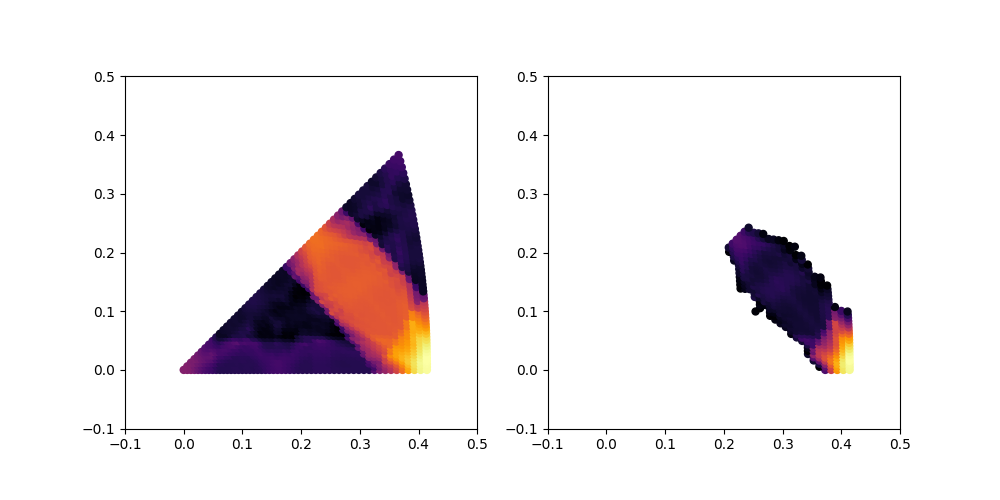

(-0.1, 0.5)

In [558]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={"projection": "stereographic"})
ax1, ax2 = ax.ravel()
ax1.scatter(rot_reg_test, s = 25, c = correlations, cmap="inferno")
ax2.scatter(filtered_xy, s = 25, c = filtered_correlation, cmap="inferno")
#ax2.imshow(zi, cmap="inferno")
#ax2.invert_yaxis()
ax1.set_xlim(-0.1, 0.5)
ax1.set_ylim(-0.1, 0.5)
ax2.set_xlim(-0.1, 0.5)
ax2.set_ylim(-0.1, 0.5)

## Doing a pre-filtering by azimuthal integration

In [562]:
@njit
def quick_full_indexation(polar_image, coordinates, intensities, fraction=0.3):
    quick_correlation = match_library_to_polar_fast(polar_image, coordinates, intensities)
    lowest = np.percentile(correlations, 100*(1-fraction))
    max_i = 0
    max_cor = 0.
    best_angle = 0.
    for i in range(intensities.shape[1]):
        if quick_correlation[i]<lowest:
            continue
        else:
            xy = coordinates[:, :, i]
            intensity = intensities[:, i]
            match = match_polar_to_template(polar_image, xy, intensity, 1)
            max_angle = np.where(match == np.max(match))[0][0]
            max_cor_a = match[max_angle]
            if max_cor_a>max_cor:
                max_i = i
                max_cor = max_cor_a
                best_angle = max_angle
    return max_i, max_cor, best_angle


In [567]:
%%time
index, correlation, angle = quick_full_indexation(polar_image, positions, intensities)

CPU times: user 253 ms, sys: 2.74 ms, total: 256 ms
Wall time: 265 ms


In [565]:
index

1071

# ^ working
-----------------------
# v highly experimental crap

## Indexing a full dataset
* first take a relevant sample

In [7]:
import hyperspy.api as hs
import pyxem as pxm
import numpy as np
import matplotlib.pyplot as plt

In [8]:
file_location = "/Users/nielscautaerts/Documents/Work/Projects/200630Gphase/Data/201009A17-FullData4xbin.hspy"
data_file = pxm.load(file_location, lazy=True)

In [9]:
data_file.axes_manager

<Axes manager, axes: (260, 200|256, 256)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               x |    260 |      0 |       0 |       2 |     nm 
               y |    200 |      0 |       0 |       2 |     nm 
---------------- | ------ | ------ | ------- | ------- | ------ 
              kx |    256 |        |    -1.6 |   0.013 | $A^{-1}$ 
              ky |    256 |        |    -1.6 |   0.013 | $A^{-1}$

In [10]:
daar = data_file.data.rechunk({0: "auto", 1: "auto", 2: None, 3: None})

In [11]:
daar.chunks

((39, 39, 39, 39, 39, 5),
 (26, 26, 26, 26, 26, 26, 26, 26, 26, 26),
 (256,),
 (256,))

In [12]:
image_test = daar[2, 3, :, :].compute()

In [13]:
from pyxem.utils.dask_tools import _get_dask_array

_get_dask_array(data_file)

,Array,Chunk
Bytes,6.82 GB,786.43 kB
Shape,"(200, 260, 256, 256)","(3, 2, 256, 256)"
Count,8711 Tasks,8710 Chunks
Type,uint16,numpy.ndarray


In [639]:
sample = data_file.inav[298.:348., 192.:245.]

In [641]:
sample.compute()

[########################################] | 100% Completed |  0.9s


In [643]:
sample.save("data/sample_with_g.hspy")

In [36]:
_get_dask_array(sample)

dask.array<array, shape=(26, 25, 256, 256), dtype=uint16, chunksize=(26, 25, 256, 256), chunktype=numpy.ndarray>

## Defining helper functions

In [518]:
from skimage.filters import gaussian
from skimage.transform import warp_polar
from numba import guvectorize, prange, njit, objmode
from numba.types import Tuple
import numpy as np

def _get_direct_beam_center(image, window=60, window_shift = (0, 0), **kwargs):
    center_y = image.shape[0]//2+window_shift[1]
    center_x = image.shape[1]//2+window_shift[0]
    start_x = max(0, center_x - window//2)
    start_y = max(0, center_y - window//2)
    end_x = min(image.shape[1], center_x + window//2)
    end_y = min(image.shape[0], center_y + window//2)
    image_window = image[start_y:end_y, start_x:end_x]
    filtered = gaussian(image_window, **kwargs)
    maximum = np.max(filtered)
    max_y, max_x = np.where(filtered == maximum)
    peak_x = start_x + max_x[0] 
    peak_y = start_y + max_y[0] 
    return peak_x, peak_y
    
        
def _image_to_polar(image, delta_r=1, delta_theta=1, find_maximum=True, **kwargs):
    half_x, half_y = image.shape[1]//2, image.shape[0]//2
    if find_maximum:
        c_x, c_y = _get_direct_beam_center(image, **kwargs)
    else:
        c_x, c_y = half_x, half_y
    r_max = int(np.ceil(np.sqrt(half_x**2 + half_y**2))/delta_r)
    output_shape = (int(round(360/delta_theta)), r_max)
    return warp_polar(image, center=(c_y, c_x), output_shape=output_shape)

In [2]:
@njit
def _circular_on_mask(X, Y, radius, center):
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    mask = dist_from_center > radius
    return mask

@njit
def _multiple_circles_mask(X, Y, point_coordinates, radii):
    image_size = X.shape
    mask = (np.zeros_like(X) == 0)
    for i in range(point_coordinates.shape[0]):
        x, y = point_coordinates[i]
        circle_mask = _circular_on_mask(X, Y, radii[i], center=(x, y))
        mask = mask & circle_mask
    return mask

def _template_to_negative_mask(point_coordinates, radius, image_size, beam_center = None):
    if beam_center is None:
        beam_center = (image_size[1]//2, image_size[0]//2)
    point_coordinates_shifted = point_coordinates.copy()
    point_coordinates_shifted[:, 0] = point_coordinates_shifted[:, 0] + beam_center[0]
    point_coordinates_shifted[:, 1] = point_coordinates_shifted[:, 1] + beam_center[1]
    h, w = image_size
    x = np.arange(w)
    y = np.arange(h)
    X, Y = np.meshgrid(x, y)
    radii = np.ones(point_coordinates.shape[0])*radius
    mask = _multiple_circles_mask(X, Y, point_coordinates_shifted, radii)
    return mask

def _invert_mask(mask):
    return 1-mask

In [3]:
def _simulations_to_arrays(simulations, max_radius = None):
    """
    Convert simulation results to arrays of diffraction spots
    
    Parameters
    ----------
    simulations : list 
        list of diffsims.sims.diffraction_simulation.DiffractionSimulation
        objects
    max_radius : float 
        limit to radius
    
    Returns
    -------
    positions : numpy.ndarray (N, 2, R)
        An array containing all (x,y) coordinates of reflections of N templates. R represents
        the maximum number of reflections; templates containing fewer
        reflections are padded with 0's at the end.
    intensities : numpy.ndarray (N, R)
        An array containing all intensities of reflections of N templates normalized to
        unit length for each template.
    """
    num_spots = [i.intensities.shape[0] for i in simulations]
    max_spots = max(num_spots)
    positions = np.zeros((len(simulations), 2, max_spots), dtype=np.int64)
    intensities = np.zeros((len(simulations), max_spots), dtype=np.float64)
    for i, j in enumerate(simulations):
        x = j.calibrated_coordinates[:,0]
        y = j.calibrated_coordinates[:,1]
        intensity = j.intensities/np.linalg.norm(j.intensities)
        if max_radius is not None:
            condition = (x**2+y**2<max_radius**2)
            x = x[condition]
            y = y[condition]
            intensity = intensity[condition]
        positions[i, 0, :x.shape[0]]=x
        positions[i, 1, :y.shape[0]]=y
        intensities[i, :intensity.shape[0]]=intensity
    return positions, intensities

In [468]:
def _get_max_image_r(image):
    return int(np.ceil(np.sqrt((image.shape[0]/2)**2 + (image.shape[1]/2)**2)))

def _cartesian_positions_to_polar(x, y, delta_r=1, delta_theta=1):
    """Vectorized implementation to get integer polar coordinates"""
    imag = (x)+1j*(y)
    r = np.rint(np.abs(imag)/delta_r).astype(np.int64)
    angle = np.rad2deg(np.angle(imag))
    theta = np.rint(np.mod(angle, 360)/delta_theta).astype(np.int64)
    return r, theta

@guvectorize(["void(float64[:,:], int64[:], int64[:], float64[:])"], '(n,m),(p),(p)->(p)', nopython=True)
def _vector_extract_pixel_intensities(image, x, y, experimental):
    for j in prange(x.shape[-1]):
        experimental[j]=image[y[j], x[j]]

@njit
def correlation_function(x, y):
    return np.sum(np.multiply(x, y))

# (["float64[:](float64[:,:], int64[:], int64[:])"]) = possible signature for compiling before
@njit
def _extract_pixel_intensities(image, x, y):
    experimental = np.zeros(x.shape, dtype=np.float64)
    for j in prange(x.shape[-1]):
        experimental[j]=image[y[j], x[j]]
    return experimental

# this doesn't work for some reason???
@guvectorize(["void(float64[:,:], int64[:], int64[:], float64[:], float64[:], float64[:])"],
             '(theta,r),(spot),(spot),(spot)->(),()', nopython=True)
def _vector_full_match_polar_to_template(polar_image, r_template, theta_template, intensities,
                                         corr, angle):
    d_theta = 360./polar_image.shape[0]
    correlations = np.zeros(polar_image.shape, dtype=np.float64)
    for i in range(polar_image.shape[0]):
        theta_compare = np.mod(theta_template + i, polar_image.shape[0])
        image_intensities = np.zeros(theta_compare.shape, dtype=np.float64)
        for j in range(theta_compare.shape[0]):
            image_intensities[j]=polar_image[theta_template[j], r_template[j]]
        correlations[i] = correlation_function(image_intensities, intensities)
    corr[0] = np.amax(correlations)
    angle[0] = np.argmax(correlations)*d_theta

########################################################
# non vectorized variant, directly using polar coords  #
########################################################
@njit
def _match_polar_to_polar_template(polar_image, r_template, theta_template, intensities):
    correlation = np.zeros(polar_image.shape[0], dtype=np.float64)
    for i in prange(polar_image.shape[0]):
        theta_compare = np.mod(theta_template + i, polar_image.shape[0])
        image_intensities = _extract_pixel_intensities(polar_image, r_template, theta_compare)
        correlation[i] = correlation_function(image_intensities, intensities)
    return correlation

#(["Tuple((float64[:],float64[:]))(float64[:,:], int64[:,:], int64[:,:], float64[:,:])"])
@njit#(parallel=True, nogil=True)
def _match_polar_to_polar_library(polar_image, r_templates, theta_templates, intensities_templates):
    correlations = np.zeros(intensities_templates.shape[0])
    angles = np.zeros(intensities_templates.shape[0])
    d_theta = 360/polar_image.shape[0]
    for i in prange(intensities_templates.shape[0]):
        intensities_template = intensities_templates[i]
        r_template = r_templates[i]
        theta_template = theta_templates[i]
        match = _match_polar_to_polar_template(polar_image, r_template, theta_template, intensities_template)
        correlations[i] = np.max(match)
        angles[i] = np.argmax(match)*d_theta
    return correlations, angles 

@njit
def _match_library_to_polar_fast(polar_image, r_templates, intensities_templates):
    polar_sum = np.sum(polar_image, axis=0)
    polar_sum = polar_sum / np.linalg.norm(polar_sum)
    coors = np.zeros(intensities_templates.shape[0], dtype=np.float64)
    for i in range(intensities.shape[0]):
        intensity = intensities_templates[i]
        r_template = r_templates[i]
        image_row = np.zeros(polar_image.shape[1], dtype=np.float64)
        for j in range(intensity.shape[0]):
            inten = intensity[j]
            r_p = r_template[j]
            image_row[r_p]=image_row[r_p]+inten
        coors[i] = correlation_function(image_row, polar_sum)
    return coors


@njit(["float64[:](float64[:,:], int64[:,:], int64[:,:], float64[:,:], float64)"],
     #parallel=True, nogil=True,
    )
def _mixed_matching_lib_to_polar(polar_image, r_templates, theta_templates, intensities_templates, fraction):
    template_indexes = np.arange(theta_templates.shape[0])
    coors = _match_library_to_polar_fast(polar_image, r_templates, intensities_templates)
    lowest = np.percentile(coors, fraction*100)
    condition = coors > lowest
    r_templates_filter = r_templates[condition]
    theta_templates_filter = theta_templates[condition]
    intensities_templates_filter = intensities_templates[condition]
    template_indexes_filter = template_indexes[condition]
    full_cors, full_angles = _match_polar_to_polar_library(polar_image,
                                                           r_templates_filter,
                                                           theta_templates_filter,
                                                           intensities_templates_filter)
    max_index_filter = np.argmax(full_cors)
    max_cor = np.amax(full_cors)
    max_angle = full_angles[max_index_filter]
    max_index = template_indexes_filter[max_index_filter]
    answer = np.array((max_index, max_cor, max_angle))
    return answer

### Testing stuff

In [15]:
image_test = daar[2, 3, :, :].compute()

In [225]:
dr = 1
dt = 1
image_polar_test = _image_to_polar(image_test, delta_r = dr, delta_theta = dt)

In [226]:
from diffsims.libraries.diffraction_library import load_DiffractionLibrary
diff_lib = load_DiffractionLibrary('./Data/phase_template_library.pickle', safety=True)

In [227]:
simulations = diff_lib["steel"]["simulations"]
max_radius = _get_max_image_r(image_test)
positions, intensities = _simulations_to_arrays(simulations, max_radius)
print(positions.shape)
print(intensities.shape)

(1596, 2, 66)
(1596, 66)


In [228]:
x = positions[:,0]
y = positions[:,1]
r, theta = _cartesian_positions_to_polar(x, y, delta_r = dr, delta_theta = dt)

In [231]:
%%time
cors, angle = _match_polar_to_polar_library(image_polar_test, r, theta, intensities)

CPU times: user 698 ms, sys: 7.24 ms, total: 705 ms
Wall time: 725 ms


In [232]:
angle

array([ 37., 217., 127., ..., 201., 201., 142.])

In [233]:
%%time
cors_f = _match_library_to_polar_fast(image_polar_test, r, intensities)

CPU times: user 1.24 ms, sys: 4 µs, total: 1.25 ms
Wall time: 1.34 ms


<IPython.core.display.Javascript object>


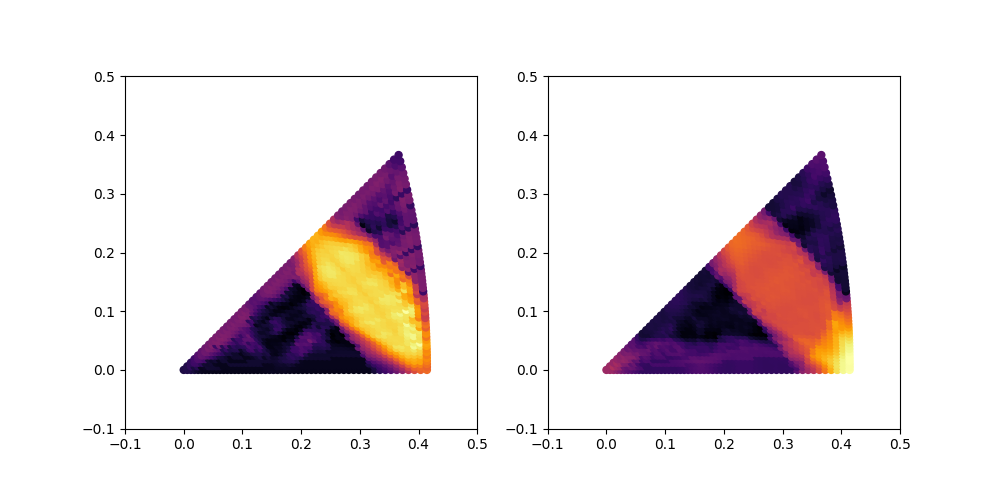

(-0.1, 0.5)

In [234]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={"projection": "stereographic"})
ax1, ax2 = ax.ravel()
ax1.scatter(rot_reg_test, s = 25, c = cors, cmap="inferno")
ax2.scatter(rot_reg_test, s = 25, c = cors_f, cmap="inferno")
ax1.set_xlim(-0.1, 0.5)
ax1.set_ylim(-0.1, 0.5)
ax2.set_xlim(-0.1, 0.5)
ax2.set_ylim(-0.1, 0.5)

<IPython.core.display.Javascript object>


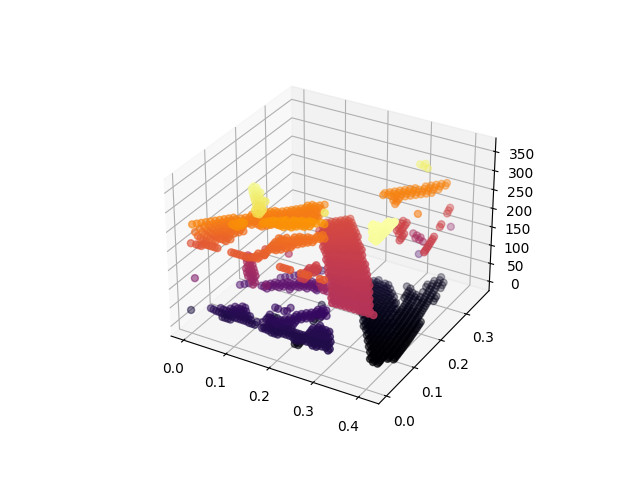

In [126]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xy = StereographicProjection.project(rot_reg_test)
ax.scatter(xy[:,0], xy[:,1], angle, s=25, c=angle, cmap="inferno")

In [415]:
%%time
max_index, max_cor, max_angle = _mixed_matching_lib_to_polar(image_polar_test, r, theta, intensities, 0.93)
print(max_index, max_cor, max_angle)

504.0 0.18718910347428358 358.0
CPU times: user 57.2 ms, sys: 1.17 ms, total: 58.3 ms
Wall time: 60.8 ms


<IPython.core.display.Javascript object>


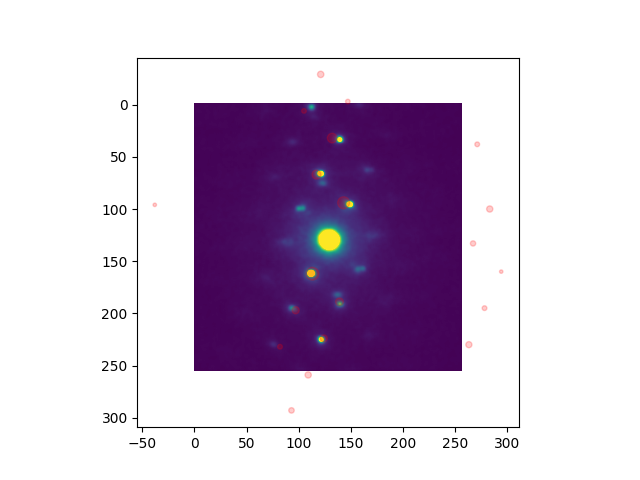

In [236]:
x_test = positions[max_index][0]
y_test = positions[max_index][1]
int_test = intensities[max_index]

fig, ax = plt.subplots()
ax.imshow(image_test, vmax=3000)
ax.scatter(x_test+128, y_test+128, s=100*np.sqrt(int_test), alpha=0.2, color="red")


<IPython.core.display.Javascript object>


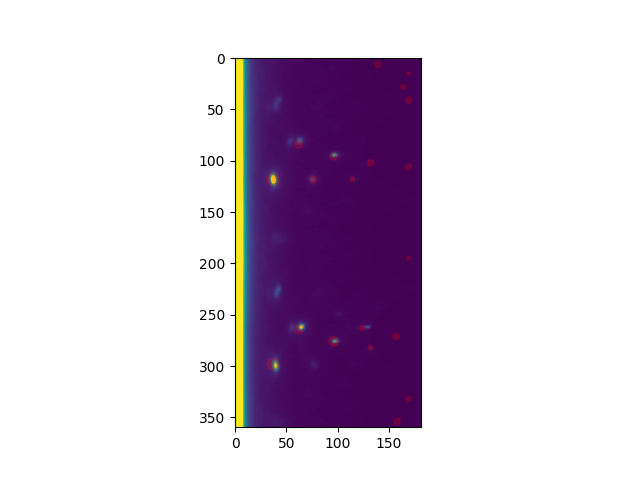

In [237]:
r_test = r[max_index]
theta_test = theta[max_index]

fig, ax = plt.subplots()
ax.imshow(image_polar_test, vmax=0.1)
ax.scatter(r_test, np.mod(theta_test+max_angle, image_polar_test.shape[0]), s=100*np.sqrt(int_test), alpha=0.2, color="red")

# Actual indexation

In [465]:
np.array(np.ndindex(12, 12))

array(<numpy.ndindex object at 0x17625a250>, dtype=object)

In [548]:
def _get_polar_pattern_shape(images, delta_r, delta_theta):
    half_x = images.shape[-1]//2
    half_y = images.shape[-2]//2
    r_dim = int(np.ceil(np.sqrt(half_x**2 + half_y**2))/delta_r)
    theta_dim = int(round(360/delta_theta))
    return (r_dim, theta_dim)


#@njit(nogil=True) with objmode(y='intp[:]'):  # annotate return type
        # this region is executed by object-mode.
@njit(nogil=True, parallel=True)
def _chunk_to_polar(images, delta_r, delta_theta, find_maximum):
    half_x = images.shape[-1]//2
    half_y = images.shape[-2]//2
    r_dim = int(np.ceil(np.sqrt(half_x**2 + half_y**2))/delta_r)
    theta_dim = int(round(360/delta_theta))
    polar_chunk = np.empty((images.shape[0], images.shape[1], theta_dim, r_dim), dtype=np.float64)
    for idx in prange(images.shape[0]):
        for idy in range(images.shape[1]):
            image = images[idx, idy]
            with objmode(polar_image='float64[:,:]'):
                polar_image=_image_to_polar(image, delta_r=delta_r,
                                   delta_theta=delta_theta, find_maximum=find_maximum)
            polar_chunk[idx, idy] = polar_image
    return polar_chunk


In [ ]:
@njit(["float64[:,:,:](float64[:,:,:,:], int64[:,:], int64[:,:], float64[:,:], float64)"],
      nogil=True,
      parallel=True,
     #parallel=True, nogil=True,
     )
def _index_chunk(polar_images, r_templates, theta_templates, intensities_templates, fraction):
    indexation_result_chunk = np.empty((polar_images.shape[0], polar_images.shape[1], 3), dtype=np.float64)
    #multi_index = np.ndindex(polar_images.shape[:-2])
    for idx in prange(polar_images.shape[0]):
        for idy in prange(polar_images.shape[1]):
            pattern = polar_images[idx, idy]
            # compute indexation_result
            indexresult = _mixed_matching_lib_to_polar(pattern,
                                                     r_templates, 
                                                     theta_templates, 
                                                     intensities_templates,
                                                     fraction)
            indexation_result_chunk[idx, idy] = indexresult
    return indexation_result_chunk

In [323]:
from pyxem.utils.dask_tools import _get_dask_array
import os
from dask.diagnostics import ProgressBar


def index_dataset_series(signal, library, phases, optimize_direct_beam=True,
                           chunks = "auto", delta_r=1, delta_theta=1,
                           keep=100, **kwargs):
        
    workers = os.cpu_count()
    result = {}
    # get the dataset as a dask array and rechunk if necessary
    data = _get_dask_array(signal)
    if chunks is None:
        pass
    elif chunks == "auto":
        data = data.rechunk({0: "auto", 1: "auto", 2: None, 3: None})
    else:
        data = data.rechunk(chunks)
    # convert to polar dataset
    r_dim, theta_dim = _get_polar_pattern_shape(data, delta_r, delta_theta)
    polar_chunking = (data.chunks[0], data.chunks[1], theta_dim, r_dim)
    polar_data = data.map_blocks(_chunk_to_polar,
                                 delta_r,
                                 delta_theta,
                                 optimize_direct_beam,
                                 dtype=np.float64,
                                 drop_axis=signal.axes_manager.signal_indices_in_array,
                                 chunks=polar_chunking,
                                 new_axis=(2, 3),
                                )
    # convert libraries of templates to polar on the fly
    max_radius = _get_max_image_r(data[0,0])
    for phase_key in phases:
        phase_library = library[phase_key]
        positions, intensities = _simulations_to_arrays(phase_library["simulations"], max_radius)
        x = positions[:,0]
        y = positions[:,1]
        r, theta = _cartesian_positions_to_polar(x, y, delta_r = delta_r, delta_theta = delta_theta)
        if keep>=1.:
            fraction = max(theta.shape[0] - keep)/theta.shape[0], 0).
        elif 0.<keep<=1.:
            fraction = 1.-keep
        else:
            raise ValueError("keep should be an integer >1 or a float [0-1]")
        # map the indexation to the block
        indexation = polar_data.map_blocks(_index_chunk,
                              r,
                              theta,
                              intensities,
                              fraction,
                              dtype=np.float64,
                              drop_axis=signal.axes_manager.signal_indices_in_array,
                              chunks=(polar_data.chunks[0], polar_data.chunks[1], 3),
                              new_axis=2,
                              )
        # wrangle data to (template_index), (orientation), (correlation)
        with ProgressBar():
            res_index = indexation.compute(scheduler="threads", num_workers=workers, optimize_graph=True)
        result[phase_key] = {}
        result[phase_key]["template_index"] = res_index[:,:,0]
        oris = phase_library["orientations"]
        orimap = oris[res_index[:,:,0].astype(np.uint64)]
        orimap[:,:,0]=res_index[:,:,2]
        result[phase_key]["orientation"] = orimap
        result[phase_key]["correlation"] = res_index[:, :, 1]
    return result 

## Testing things again

In [420]:
sample = hs.load("data/sample_with_g.hspy")

In [551]:
%%time
polar_sample = _chunk_to_polar(sample.data, 1, 1, True)

CPU times: user 8.77 s, sys: 842 ms, total: 9.61 s
Wall time: 3.97 s


In [543]:
polar_sample.shape

(26, 25, 360, 182)

In [473]:
%%time
indexation = _index_chunk(polar_sample, r, theta, intensities, 0.93)

CPU times: user 1min 4s, sys: 401 ms, total: 1min 4s
Wall time: 21.3 s


In [424]:
indexation.shape

(26, 25, 3)

<IPython.core.display.Javascript object>


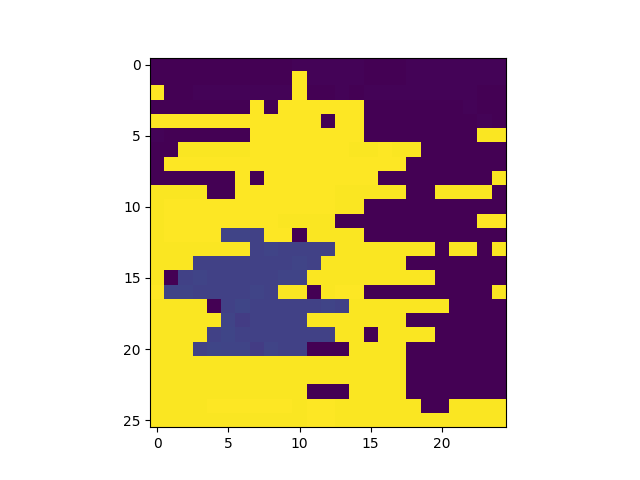

In [427]:
fig, ax = plt.subplots()
ax.imshow(indexation[:,:,2])

In [545]:
file_location = "/Users/nielscautaerts/Documents/Work/Projects/200630Gphase/Data/201009A17-FullData4xbin.hspy"
data_file = pxm.load(file_location, lazy=True)

In [546]:
lazy_data = data_file.data
lazy_data = lazy_data.rechunk({0: "auto", 1: "auto", 2: None, 3: None})
lazy_data

dask.array<rechunk-merge, shape=(200, 260, 256, 256), dtype=uint16, chunksize=(39, 26, 256, 256), chunktype=numpy.ndarray>

In [555]:
r_dim, theta_dim = _get_polar_pattern_shape(lazy_data, 1, 1)
polar_chunking = (lazy_data.chunks[0], lazy_data.chunks[1], theta_dim, r_dim)
polar_data = lazy_data.map_blocks(_chunk_to_polar,
                                  1,
                                  1,
                                  True,
                             dtype=np.float64,
                             drop_axis=data_file.axes_manager.signal_indices_in_array,
                             chunks=polar_chunking,
                             new_axis=(2, 3),
                            )
polar_data

dask.array<_chunk_to_polar, shape=(200, 260, 360, 182), dtype=float64, chunksize=(39, 26, 360, 182), chunktype=numpy.ndarray>

In [556]:
phase_library = diff_lib["steel"]
positions, intensities = _simulations_to_arrays(phase_library["simulations"], 182)
x = positions[:,0]
y = positions[:,1]
r, theta = _cartesian_positions_to_polar(x, y, delta_r = 1, delta_theta = 1)
# map the indexation to the block
indexation = polar_data.map_blocks(_index_chunk,
                      r,
                      theta,
                      intensities,
                      0.93,
                      dtype=np.float64,
                      drop_axis=data_file.axes_manager.signal_indices_in_array,
                      chunks=(polar_data.chunks[0], polar_data.chunks[1], 3),
                      new_axis=2,
                      )
indexation

dask.array<_index_chunk, shape=(200, 260, 3), dtype=float64, chunksize=(39, 26, 3), chunktype=numpy.ndarray>

In [558]:
with ProgressBar():
    res_index_2 = indexation.compute(scheduler="threads", num_workers=4)

[########################################] | 100% Completed | 30min 43.5s


In [337]:
with ProgressBar():
    res_index = indexation.compute(scheduler="threads", num_workers=4)

[########################################] | 100% Completed | 48min 41.6s


In [338]:
res_index.shape

(200, 260, 3)

In [343]:
phase_key="steel"
result = {}
result[phase_key] = {}
result[phase_key]["template_index"] = res_index[:,:,0]
oris = diff_lib[phase_key]["orientations"]
orimap = oris[res_index[:,:,0].astype(np.uint64)]
orimap[:,:,0]=res_index[:,:,2]
result[phase_key]["orientation"] = orimap
result[phase_key]["correlation"] = res_index[:, :, 1]

In [344]:
result

{'steel': {'template_index': array([[ 635.,  635.,  635., ...,  757.,  757.,  635.],
         [ 635.,  635.,  635., ...,  635.,  635.,  757.],
         [ 757.,  757.,  757., ...,  635.,  635.,  757.],
         ...,
         [ 757.,  757.,  757., ...,  591.,  591.,  676.],
         [ 757.,  757.,  757., ...,  591.,  591.,  757.],
         [ 757.,  757.,  757., ...,  503.,  503., 1259.]]),
  'orientation': array([[[359.        ,  43.27970353,  80.86170816],
          [359.        ,  43.27970353,  80.86170816],
          [359.        ,  43.27970353,  80.86170816],
          ...,
          [  0.        ,  42.5070586 ,  78.13084376],
          [  0.        ,  42.5070586 ,  78.13084376],
          [359.        ,  43.27970353,  80.86170816]],
  
         [[359.        ,  43.27970353,  80.86170816],
          [359.        ,  43.27970353,  80.86170816],
          [359.        ,  43.27970353,  80.86170816],
          ...,
          [358.        ,  43.27970353,  80.86170816],
          [358.     

In [349]:
import pickle
with open('Data/steel-result-100.pickle', 'wb') as handle:
    pickle.dump(result, handle, protocol=pickle.HIGHEST_PROTOCOL)


<IPython.core.display.Javascript object>


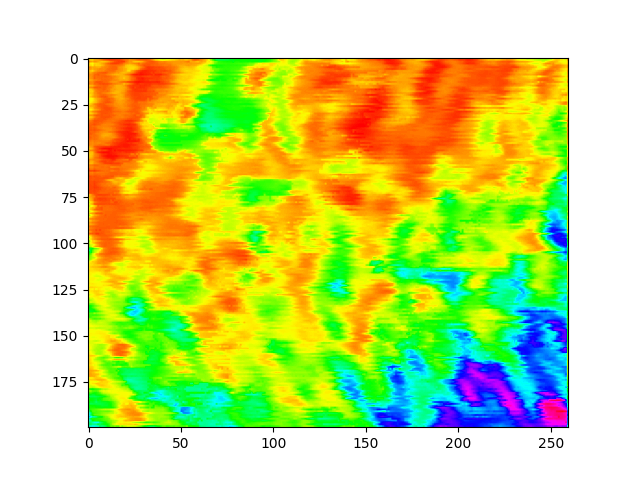

In [444]:
fig, ax = plt.subplots()
ax.imshow(res_index_2[:,:,1], cmap = "hsv")

In [364]:
result["steel"]["orientation"].reshape((200*260, 3))

array([[359.        ,  43.27970353,  80.86170816],
       [359.        ,  43.27970353,  80.86170816],
       [359.        ,  43.27970353,  80.86170816],
       ...,
       [358.        ,  43.11844878,  83.16453893],
       [358.        ,  43.11844878,  83.16453893],
       [ 15.        ,  43.11400121,  63.18333899]])

In [372]:
def result_to_array(result, phase):
    angles = result[phase]["orientation"]
    ys, xs = angles.shape[:-1]
    y = np.arange(ys)
    x = np.arange(xs)
    X, Y = np.meshgrid(x, y)
    Y = Y.ravel()
    Y = Y.reshape(Y.shape[0],-1)
    X = X.ravel().reshape(Y.shape[0],-1)
    angles = angles.reshape((ys*xs, 3))
    phase_array = np.ones(X.shape).reshape(Y.shape[0],-1)
    quality = result[phase]["correlation"].reshape(Y.shape[0],-1)
    asciform = np.hstack([X, Y, angles, phase_array, quality])
    return asciform
    

In [376]:
np.savetxt("Data/steel-result.txt", result_to_array(result, "steel"), delimiter="\t", newline="\r\n")

In [326]:
from dask.distributed import Client
client = Client()

In [327]:
index_result = index_dataset_series(data_file, diff_lib, ["steel"],
                                     chunks = "auto", keep=200)

[########################################] | 100% Completed |  1hr 25min 56.9s


KeyError: 'orientations'